In [3]:
pip install keras music21 numpy

In [1]:
import numpy as np
import music21
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import random
import sys

In [2]:
# Prepare the notes from the MIDI files
def get_notes_from_midi(midi_files):
    all_notes = []
    for file in midi_files:
        midi = music21.converter.parse(file)  # Parse the MIDI file
        for element in midi.flat.notes:  # Loop over the notes in the file
            if isinstance(element, music21.note.Note):  # If it's a note
                all_notes.append(str(element.pitch))  # Append note pitch (e.g., 'C4')
            elif isinstance(element, music21.note.Rest):  # If it's a rest
                all_notes.append('rest')  # Append 'rest' for a rest
    return all_notes

In [3]:
# Prepare sequences for training
def prepare_sequences(notes, seq_length=100):
    char_to_int = {char: number for number, char in enumerate(sorted(set(notes)))}
    int_to_char = {number: char for char, number in char_to_int.items()}

    network_input = []
    network_output = []

    for i in range(len(notes) - seq_length):
        sequence_in = notes[i:i + seq_length]
        sequence_out = notes[i + seq_length]
        network_input.append([char_to_int[note] for note in sequence_in])
        network_output.append(char_to_int[sequence_out])

    # Reshape for LSTM model input
    network_input = np.reshape(network_input, (len(network_input), seq_length, 1))
    network_input = network_input / float(len(char_to_int))  # Normalize input
    network_output = to_categorical(network_output)

    return network_input, network_output, char_to_int, int_to_char


In [4]:
# Build the LSTM model
def build_model(seq_length, num_classes):
    model = Sequential()
    model.add(LSTM(512, input_shape=(seq_length, 1), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(512))
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

In [12]:
# Generate new music using the trained model
def generate_music(model, char_to_int, int_to_char, seq_length, generate_length=200):
    start_index = random.randint(0, max(0, len(char_to_int) - seq_length - 1))
    sequence = [char_to_int[char] for char in list(char_to_int.keys())[start_index:start_index + seq_length]]

    prediction_output = []

    for _ in range(generate_length):
        # Prepare the sequence for prediction
        prediction_input = np.reshape(sequence, (1, len(sequence), 1))
        prediction_input = prediction_input / float(len(char_to_int))

        # Predict the next note
        prediction = model.predict(prediction_input, verbose=0)
        index = np.argmax(prediction)
        result = int_to_char[index]
        prediction_output.append(result)

        # Update the sequence
        sequence.append(index)
        sequence = sequence[1:len(sequence)]

    return prediction_output

In [6]:
# Convert generated output to a MIDI file
def create_midi(prediction_output, file_name="generated_music.mid"):
    stream = music21.stream.Stream()

    for note in prediction_output:
        if '.' in note or note.isdigit():  # It's a chord
            chord_notes = note.split('.')
            chord_notes = [music21.note.Note(n) for n in chord_notes]
            chord = music21.chord.Chord(chord_notes)
            stream.append(chord)
        else:  # It's a note
            stream.append(music21.note.Note(note))

    stream.write('midi', fp=file_name)

In [8]:
midi_files = ['Adson_John_-_Courtly_Masquing_Ayres.mid', 'Titantic.mid']  # Replace with your MIDI file paths
all_notes = get_notes_from_midi(midi_files)

# Prepare input and output sequences
seq_length = 100
network_input, network_output, char_to_int, int_to_char = prepare_sequences(all_notes, seq_length)

# Build and train the model
model = build_model(seq_length, len(char_to_int))

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=10, channel=None, data=b'By J\xfalio Feliz'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/music21/stream/base.py:3689: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
model.fit(network_input, network_output, epochs=20, batch_size=64)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 4.1058
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 3.9178
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 3.9278
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 3.9979
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 3.9542
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 3.9774
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 3.9092
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 3.9184
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 3.8438
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 3.8111
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 3.7946
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 3.7444
Epoch 13/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 3.7455
Epoch 14/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 3.7050
Epoch 15/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 3.6254
Epo

In [13]:
# Generate new music
generated_notes = generate_music(model, char_to_int, int_to_char, seq_length)

# Create a MIDI file from generated notes
create_midi(generated_notes)
print("Music generated and saved as generated_music.mid")

Music generated and saved as generated_music.mid


In [15]:
!pip install ipython pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 57.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.4 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=6d4c5f51fc2e68dda8df3fce599adc5631b729ee0f3ae483062913f750fb821b
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [18]:
!apt-get update
!apt-get install musescore3 -y  # Install MuseScore 3

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,632 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,790 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packa

In [19]:
import music21
import os

# Get the path to the MuseScore executable
mscore_path = '/usr/bin/mscore3'  # Update with the correct path if needed

# Set the music21 environment settings
us = music21.environment.UserSettings()
us['musicxmlPath'] = mscore_path
us['musescoreDirectPNGPath'] = mscore_path

# Now you should be able to call midi.show() without errors

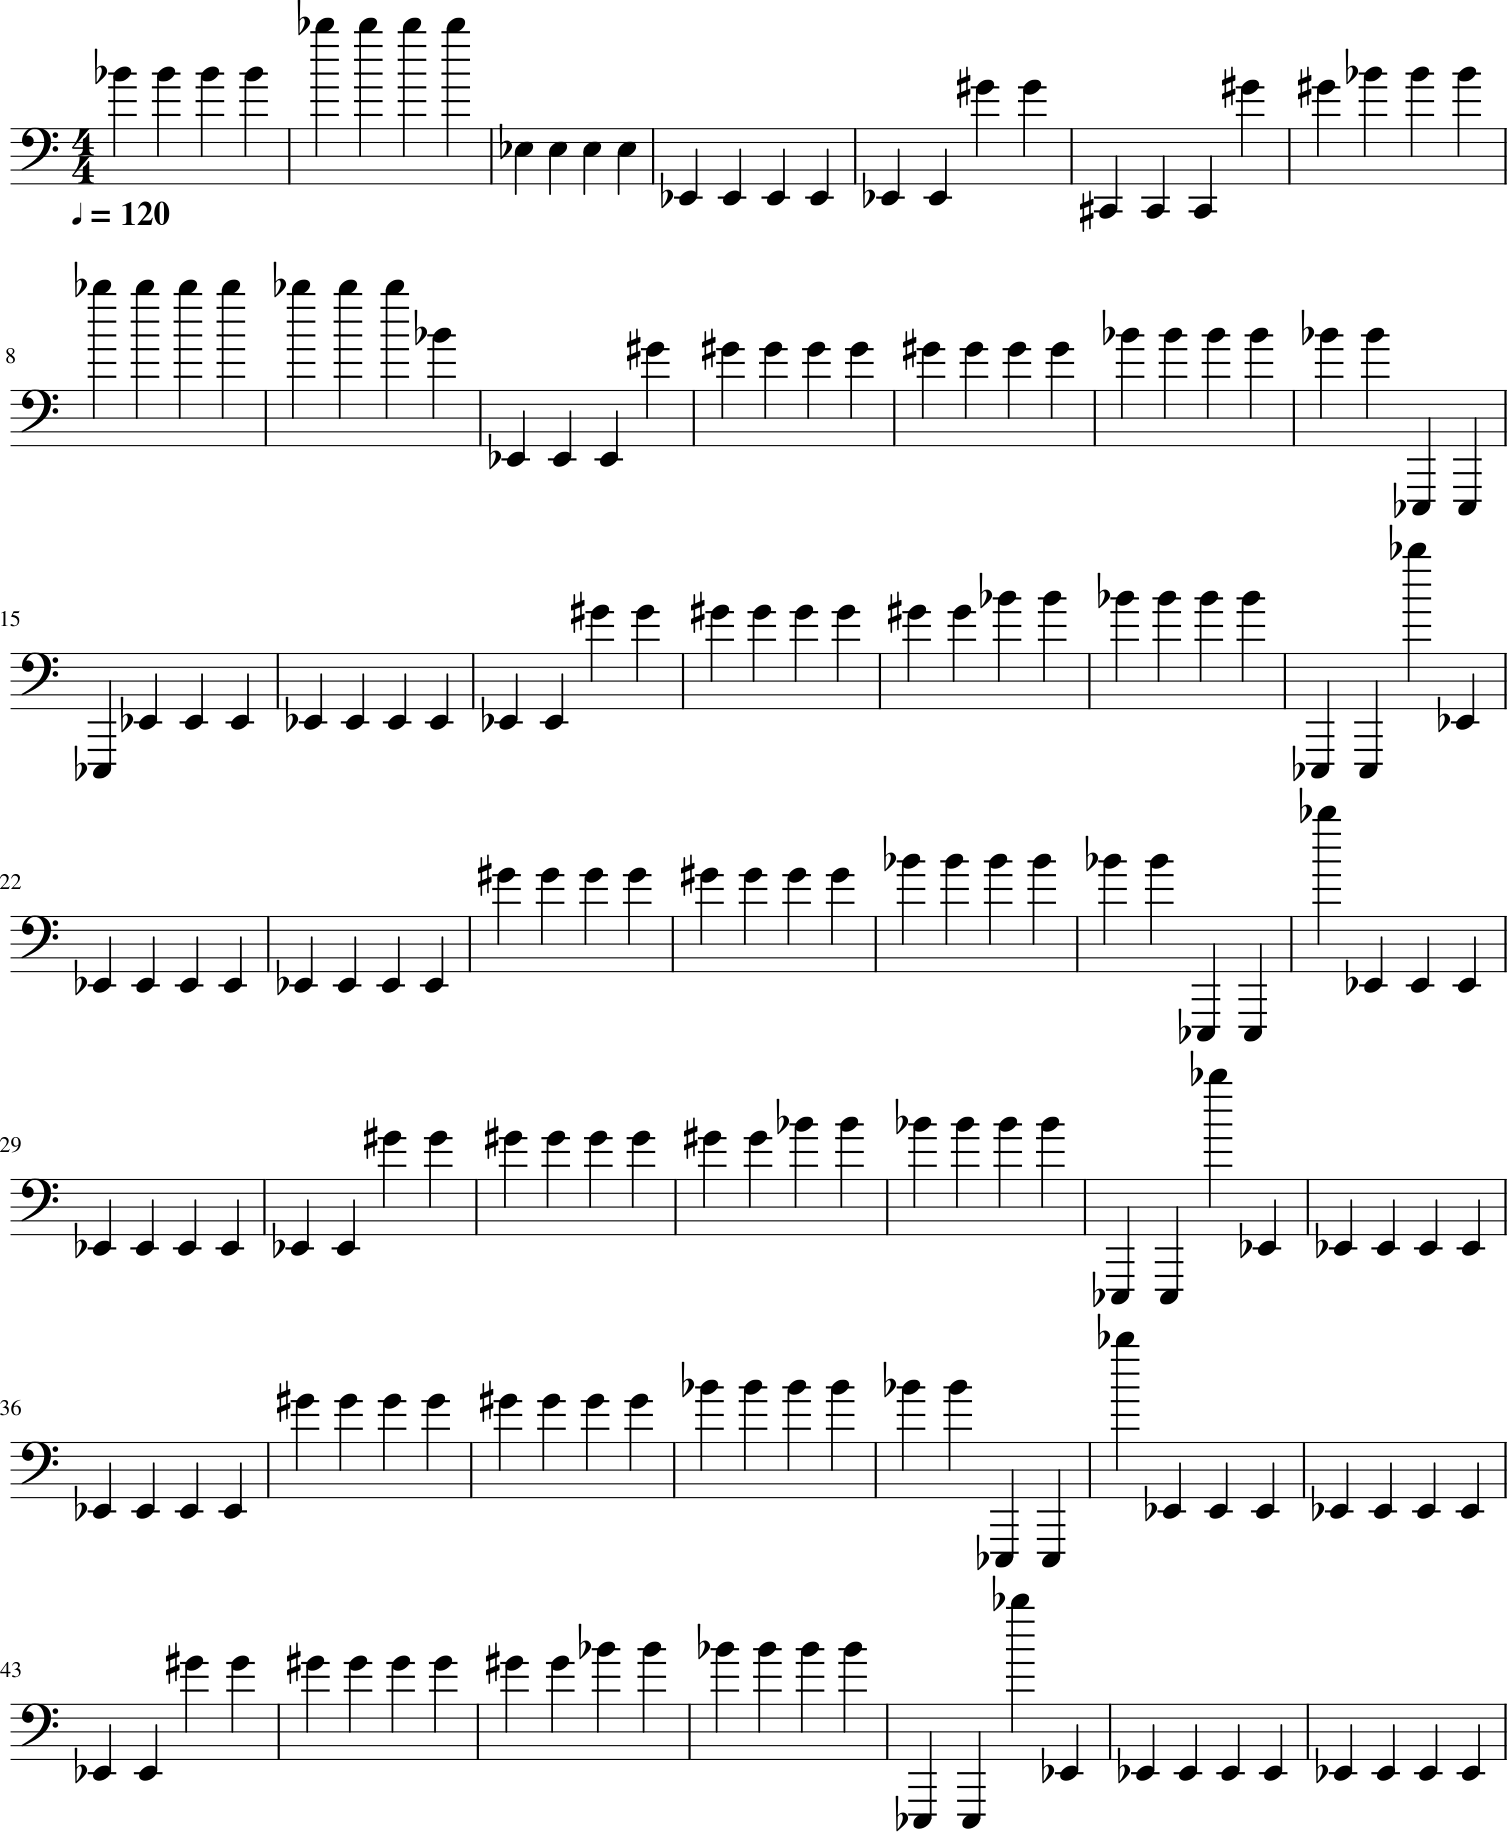

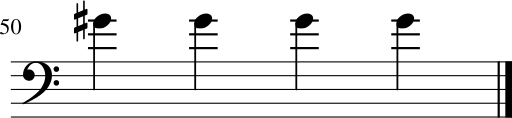

In [20]:
import numpy as np
import music21
import random
from IPython.display import Audio

# Path to the generated MIDI file
midi_path = "/content/generated_music.mid"

# Play the generated MIDI file
Audio(midi_path)

# Optionally, show the score in a readable format using music21
midi = music21.converter.parse(midi_path)
midi.show()
